# Setup

# TODO:

priorities:

IMPORTANT: why does inhibition alone work (adaptation = 0) for the central analysis variations

3. get fig 3 to use multiple models
    take a look at fig 3 for a multi-level mode (maybe it's better for the unnormalized lengths)
    
figure 5
instead of showing raw masks - show the peaks used to select the bandwidths

- power analysis for aim 2
- measures for aim 2 (better than the ones we have? look at interaction)

### figure 6
- figure out a good way to look at sensitivity to inhibition pattern
- run the sensitivity analyses
    - in progress
    - when done, start working on figure 6

In [1]:
include(joinpath("..","src","setup.jl"))

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


RObject{VecSxp}
$rcalljl_options
$rcalljl_options$height
[1] 360

$rcalljl_options$width
[1] 432




In [2]:
datadir = joinpath("..","data","count_lengths","run_2018-11-26")

"../data/count_lengths/run_2018-11-26"

In [3]:
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
for_results_in(joinpath(datadir,"data"),reinterpret="reinterpret") do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,0.2,2,2018-11-26T17:38:30.128,1
2,11.4,1,2018-11-26T17:38:30.128,1
3,0.4,2,2018-11-26T17:38:30.128,1
4,5.1,1,2018-11-26T17:38:30.128,1
5,0.4,2,2018-11-26T17:38:30.128,1
6,18.6,1,2018-11-26T17:38:30.128,1


# Figure 4A

In [5]:
HERR

(stream = 0.1251241594611916, lengths = 0.2773479452054795)

In [6]:
hstr,hlen = human_error_by_sid(resample=1000,N=1);

In [7]:
mean(hlen.x1)

0.27617534246575337

In [128]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params[fields])))
df_summary = by(params,fields) do row
    next!(progress)
    err = model_error(df,params;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = err.stream,length_error = err.lengths,eratio = error_ratio(err))
end

dfplot_ind = @linq df_summary |>
    rename_levels_for([:stream_error,:length_error,:eratio]) |>
    transform(a = packaxes(:c_a), m = packaxes(:c_m), rand = randn(length(:c_a))) |>
    transform(eratio_str = fmt.("01.2f",:eratio))
              
head(dfplot_ind)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


,c_a,c_m,level,stream_error,length_error,eratio,a,m,rand,eratio_str
,Float64,Float64,String,Float64,Float64,Float64,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,0.474594,0.434955,2.70512,0.0,0.0,-1.35563,2.71
2,0.0,5.0,Peripheral,0.261357,0.318326,1.63619,0.0,1.5,0.124735,1.64
3,0.0,15.0,Peripheral,0.265539,0.388889,1.78409,0.0,2.5,-1.29288,1.78
4,0.0,44.0,Peripheral,0.262928,1.0,2.90978,0.0,3.5,-0.359912,2.91
5,0.0,130.0,Peripheral,0.26317,1.0,2.91075,0.0,4.5,-0.214328,2.91
6,0.0,390.0,Peripheral,0.262932,1.0,2.9098,0.0,5.5,-1.47462,2.91


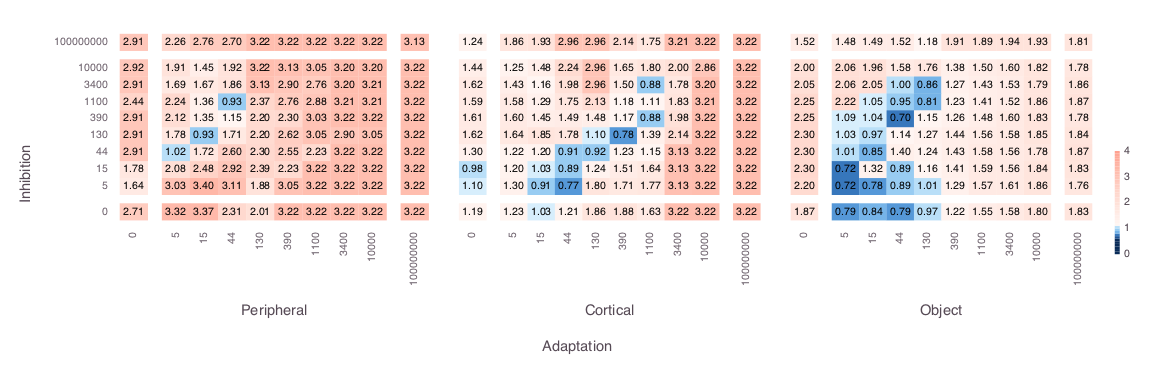

false

In [129]:
xvals = sort!(unique(dfplot_ind.a));
yvals = sort!(unique(dfplot_ind.m));

pl = plot(dfplot_ind,x=:a,y=:m,color=:eratio,xgroup=:level,label=:eratio_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Scale.x_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot_ind.c_a)),
                       Scale.y_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot_ind.c_m)),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(minvalue=0,maxvalue=4,colormap=colorscale("RdBu",reverse=true,minvalue=0.0,maxvalue=4,colorstop=8,colorstart=0.5,midvalue=1.1)),
     Guide.colorkey(title=""),
     Theme(grid_line_width=0inch,point_label_font_size=8pt,point_label_color=colorant"black"))
draw(PDF(joinpath(plotdir,"fig4A.pdf"),8inch,3.5inch),pl)
draw(PNG(12inch,4inch),pl)

# Figure 4B-C

In [8]:
using DependentBootstrap

In [20]:
head(dfplot_ind)

,c_a,c_m,level,eratio,a,m,rand,eratio_str
,Float64,Float64,String,Float64,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,2.66482,0.0,0.0,-0.810092,2.66
2,0.0,5.0,Peripheral,1.61496,0.0,1.5,0.669571,1.61
3,0.0,15.0,Peripheral,1.73264,0.0,2.5,0.102604,1.73
4,0.0,44.0,Peripheral,2.85368,0.0,3.5,-0.853897,2.85
5,0.0,130.0,Peripheral,2.85304,0.0,4.5,-0.128642,2.85
6,0.0,390.0,Peripheral,2.85365,0.0,5.5,0.181517,2.85


In [130]:
hstr,hlen = human_error_by_sid(resample=50,N=1);
dfstr_ind = vcat(DataFrame(kind=dfplot_ind.level,error=dfplot_ind.stream_error),DataFrame(kind="human",error=hstr.x1));
dflen_ind = vcat(DataFrame(kind=dfplot_ind.level,error=dfplot_ind.length_error),DataFrame(kind="human",error=hlen.x1));

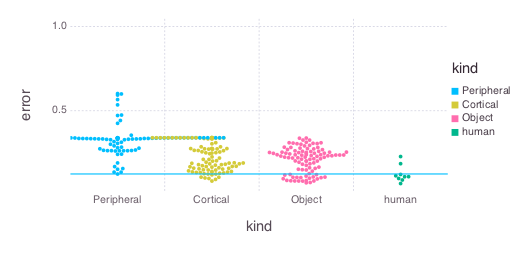

In [166]:
strplot = plot(dfstr_ind,y=:error,x=:kind,color=:kind,intercept=[mean(hstr.x1)],slope=[0],Geom.abline,Geom.beeswarm(padding=0.05mm),
    Coord.cartesian(ymax=1.0),Theme(point_size=0.5mm))
draw(PNG(5.5inch,2.75inch),strplot)
draw(PDF(joinpath(plotdir,"fig4B.pdf"),5.5inch,2.75inch),strplot)

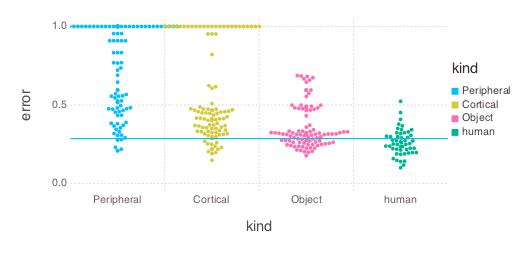

In [167]:
strplot = plot(dflen_ind,y=:error,x=:kind,color=:kind,intercept=[mean(hlen.x1)],slope=[0],Geom.abline,Geom.beeswarm(padding=0.05mm),Theme(point_size=0.5mm))
draw(PNG(5.5inch,2.75inch),strplot)
draw(PDF(joinpath(plotdir,"fig4C.pdf"),5.5inch,2.75inch),strplot)

In [133]:
bootstats = CSV.read("bootstats.csv")
head(bootstats)

,level,mean,min
,String⍰,Float64⍰,Float64⍰
1,Peripheral,2.6322,0.90404
2,Cortical,1.91128,0.747204
3,Object,1.48796,0.680741
4,Peripheral,2.6322,0.90404
5,Cortical,1.91128,0.747204
6,Object,1.48796,0.680741


In [50]:
num_sims = 20
allbootstats = []
params6 = @where(params,:Δf .== 6)
@showprogress for indices in dbootinds(1:num_sims,numresample=1000)
    df_summary = by(params6,fields) do row
        err = model_error(df,params;(k => row[1,k] for k in fields)...)
        DataFrame(eratio = error_ratio(err))
    end
    push!(allbootstats,by(rename_levels_for(df_summary,:eratio),:level) do x
        DataFrame(mean = mean(x.eratio),min = minimum(x.eratio))
    end)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:22:00


In [52]:
bootstats = vcat(allbootstats...)
CSV.write("bootstats.csv",bootstats)

"bootstats.csv"

In [53]:
stats = by(bootstats,:level) do x
    meanl,meanu = quantile(skipmissing(x.mean),[0.025,0.975])
    minl,minu = quantile(skipmissing(x.min),[0.025,0.975])
    DataFrame(mean = mean(skipmissing(x.mean)),meanl = meanl,meanu = meanu,
        min = mean(skipmissing(x.min)),minl = minl,minu = minu)
end

,level,mean,meanl,meanu,min,minl,minu
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,Peripheral,2.6322,2.6322,2.6322,0.90404,0.90404,0.90404
2,Cortical,1.91128,1.91128,1.91128,0.747204,0.747204,0.747204
3,Object,1.48796,1.48796,1.48796,0.680741,0.680741,0.680741


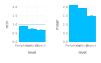

In [57]:
pl = hstack(plot(stats,x=:level,y=:min,ymin=:minl,ymax=:minu,intercept=[1.0],slope=[0],
                Geom.errorbar,Geom.bar,Geom.abline,Coord.cartesian(ymax=2.0),Guide.xticks(orientation=:horizontal)),
            plot(stats,x=:level,y=:mean,ymin=:meanl,ymax=:meanu,Geom.errorbar,
                Geom.bar,Coord.cartesian(ymax=2.0),Guide.xticks(orientation=:horizontal)))
draw(SVG(4inch,2.5inch),pl)

# Figure 3

In [ ]:
# TODO: we might get a better fit using the multi-level parameters

In [139]:
best_models = @where(df_summary,:eratio .<= 1.0)[[:f_c_a,:f_c_m,:s_c_a,:s_c_m,:t_c_a,:t_c_m]]
best_params = map(AuditoryBistabilityLE.read_params,eachrow(best_models))
len = plot_lengths_data(df,params,best_params,normlengths=true)

(human = [0.0952138, 0.226794, 0.226794, 0.226794, 0.226794, 0.226794, 0.226794, 0.226794, 0.226794, 0.226794  …  16.138, 17.749, 19.4418, 23.0753, 25.0168, 25.0168, 33.6248, 38.4398, 40.9763, 46.3094], simulation = [0.694647, 4.06476, 1.72152, 0.884818, 0.829496, 0.418772, 2.17072, 13.1746, 1.18637, 1.92379  …  1.5985, 0.821585, 1.10158, 0.404349, 0.457898, 4.67462, 1.78631, 0.374336, 1.10158, 2.30065])

In [140]:
p1 = plot_stream(df,params,best_params)
p2 = len |> plot_lengths_qq;

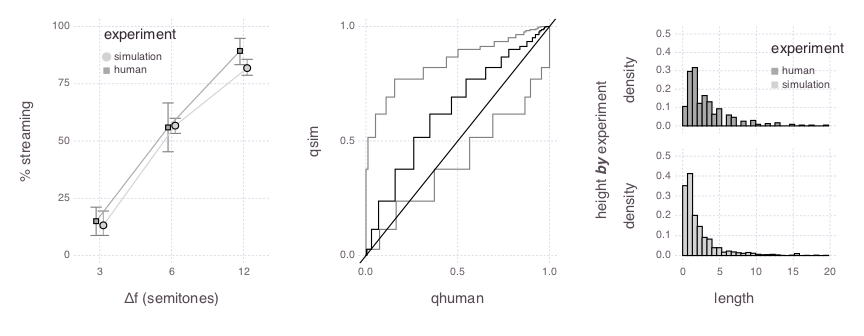

┌ Warning: Ignoring ~0.0% of human data
└ @ Main /Users/davidlittle/googledrive/Work/Software/bistable/src/plotting.jl:269


false

In [141]:
p3 = plot_lengths_hist(len,xmax=20,binstep=0.66)

draw(PNG(9inch,3.5inch),hstack(p1,p2,p3))

# Figure 5

In [76]:
datadir_all = joinpath("..","data","count_lengths","run_2018-11-28")
datadir_selected = joinpath("..","data","count_lengths","run_2018-11-30")

"../data/count_lengths/run_2018-11-30"

In [77]:
params_all = load_params(joinpath(datadir_all,"params.jld2"))
params_all[:pindex] = 1:size(params_all,1)
settings = joinpath(srcdir,"settings.toml")

results = []
for_results_in(joinpath(datadir_all,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df_all = vcat(results...);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


In [78]:
params_selected = load_params(joinpath(datadir_selected,"params.jld2"))
params_selected[:pindex] = 1:size(params_selected,1)
settings = joinpath(srcdir,"settings.toml")

results = []
for_results_in(joinpath(datadir_selected,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df_selected = vcat(results...);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


In [150]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params_all[fields])))
df_summary_all = by(params_all,fields) do row
    next!(progress)
    err = model_error(df_all,params_all;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = err.stream,length_error = err.lengths,eratio = error_ratio(err),pindex = row.pindex[1])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:09


,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,stream_error,length_error,eratio,pindex
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.306539,0.463617,2.08686,1
2,0.0,5.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.291946,0.360011,1.83593,2
3,0.0,63.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.254462,1.0,2.87595,3
4,0.0,790.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.254462,1.0,2.87595,4
5,0.0,10000.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.254462,1.0,2.87595,5
6,0.0,0.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.302625,0.417442,1.98537,6
7,0.0,5.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.301851,0.417123,1.98168,7
8,0.0,63.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.254462,1.0,2.87595,8
9,0.0,790.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.254462,1.0,2.87595,9


In [149]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params_selected[fields])))
df_summary_selected = by(params_selected,fields) do row
    next!(progress)
    err = model_error(df_selected,params_selected;(k => row[1,k] for k in fields)...)
    DataFrame(stream_error = err.stream,length_error = err.lengths, eratio = error_ratio(err),pindex = row.pindex[1])
end

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:01┌ Warning: Expected 3 parameter entries. 
│   
Instead, only found entires:  = 
Instead, only found entires: 
│   string(found) = 2×36 DataFrame
│ Row │ f_W_m_σ │ f_c_m   │ t_c_a   │ t_c_m   │ f         │ t_W_m_c │ t_c_x   │ f_c_x   │ t_W_m_σ_t │ s_τ_σ     │ f_c_a   │ f_c_σ   │ s_c_m   │ f_τ_a     │ s_c_σ   │ Δt        │ s_τ_m     │ s_c_x   │ t_W_m_σ_ϕ │ t_τ_a     │ s_c_a   │ t_τ_m     │ t_c_σ   │ t_τ_x     │ s_W_m_c │ s_τ_a     │ f_W_m_c │ t_τ_σ     │ f_τ_σ     │ f_τ_x     │ Δf    │ t_W_m_σ_N │ f_τ_m     │ s_τ_x     │ s_W_m_σ │ pindex │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Quantity… │ Float64 │ Float64 │ Float64 │ Float64   │ Quantity… │ Float64 │ Float64 │ Float64 │ Quantity… │ Float64 │ Quantity… │ Quantity… │ Float64 │ Float64   │ Quantity… │ Float64 │ Quantity… │ Float64 │ Quantity… │ Float64 │ Quantity… │ Float64 │ Quantity… │ Quantity… │ Quantity… │ Int64 │ Float64   │ Quantity… │ Quantity… │ Float

,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,stream_error,length_error,eratio,pindex
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,5.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.133125,0.278082,1.04896,1
2,5.0,5.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.43188,0.281849,2.2498,2
3,5.0,63.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.135811,0.187769,0.89179,3
4,5.0,0.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.150671,0.333638,1.22236,4
5,5.0,5.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.432949,0.327581,2.33909,5
6,5.0,63.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,0.136061,0.221569,0.955628,6
7,5.0,0.0,0.2,0.0,0.0,0.2,63.0,0.0,0.2,0.146599,0.263888,1.07641,7
8,5.0,5.0,0.2,0.0,0.0,0.2,63.0,0.0,0.2,0.423751,0.302198,2.25514,8
9,5.0,63.0,0.2,0.0,0.0,0.2,63.0,0.0,0.2,0.132938,0.205246,0.912802,9


In [156]:
# if there is a selected entry with a revised eratio, use that value

df_summary_selected[:procedure] = "selected"
df_summary_all[:procedure] = "survey"
function favor_selected(vals,procedure)
    selected = findfirst(procedure .== "selected")
    if selected isa Nothing
        @assert length(vals) == 1
        first(vals)
    else
        vals[selected]
    end
end
    
df_summary_multi = @linq vcat(df_summary_all,df_summary_selected) |>
    by(fields,eratio = favor_selected(:eratio,:procedure),
              stream_error = favor_selected(:stream_error,:procedure),
              length_error = favor_selected(:length_error,:procedure))
head(df_summary_multi)

,f_c_a,f_c_m,f_c_σ,s_c_a,s_c_m,s_c_σ,t_c_a,t_c_m,t_c_σ,eratio,stream_error,length_error
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,2.08686,0.306539,0.463617
2,0.0,5.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,1.83593,0.291946,0.360011
3,0.0,63.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,2.87595,0.254462,1.0
4,0.0,790.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,2.87595,0.254462,1.0
5,0.0,10000.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,2.87595,0.254462,1.0
6,0.0,0.0,0.2,0.0,0.0,0.2,5.0,0.0,0.2,1.98537,0.302625,0.417442


In [159]:
mlevels = [(vars = [:f_c_a,:f_c_m], name = "Peripheral"),
          (vars = [:s_c_a,:s_c_m], name = "Cortical"),
          (vars = [:t_c_a,:t_c_m], name = "Object")]
dflevels = map(mlevels) do level
    result = by(df_summary_multi,level.vars) do slice
       DataFrame(c_a = first(slice[level.vars[1]]),c_m = first(slice[level.vars[2]]),
                 level = level.name, 
                 eratio = minimum(skipmissing(slice.eratio)),
                 stream_error = slice.stream_error[argmin(coalesce.(slice.eratio,-Inf))],
                 length_error = slice.length_error[argmin(coalesce.(slice.eratio,-Inf))])
            
    end
    result[[:c_a,:c_m,:level,:eratio,:stream_error,:length_error]]
end

dfplot = @linq vcat(dflevels...) |>
    transform(a = packaxes(:c_a,maxpad=false), m = packaxes(:c_m,maxpad=false)) |>
    transform(eratio_str = fmt.("01.2f",:eratio))
head(dfplot)

,c_a,c_m,level,eratio,stream_error,length_error,a,m,eratio_str
,Float64,Float64,String,Float64,Float64,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,1.15532,0.194559,0.203245,0.0,0.0,1.16
2,0.0,5.0,Peripheral,0.816305,0.115321,0.19121,0.0,1.5,0.82
3,0.0,63.0,Peripheral,1.15565,0.18868,0.21606,0.0,2.5,1.16
4,0.0,790.0,Peripheral,0.956502,0.146695,0.199184,0.0,3.5,0.96
5,0.0,10000.0,Peripheral,1.00337,0.147235,0.223233,0.0,4.5,1.00
6,5.0,0.0,Peripheral,0.770109,0.106877,0.18451,1.5,0.0,0.77


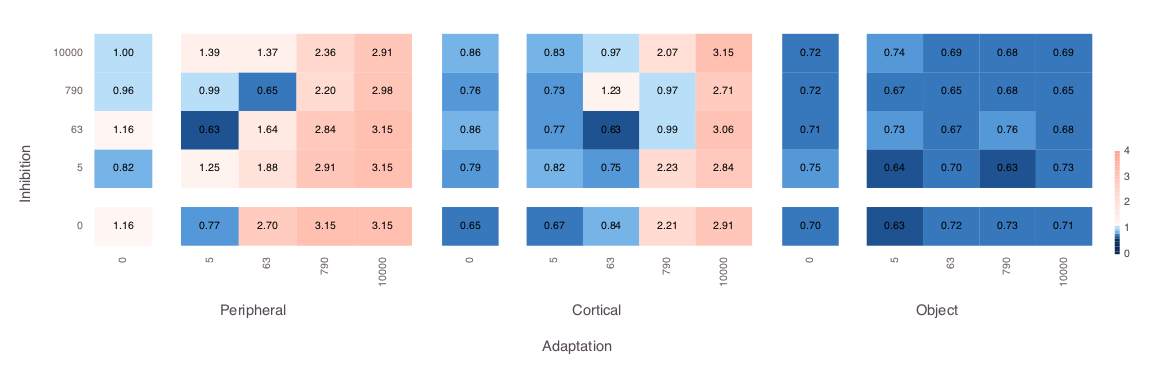

false

In [160]:
xvals = sort!(unique(dfplot.a));
yvals = sort!(unique(dfplot.m));

pl = plot(dfplot,x=:a,y=:m,color=:eratio,xgroup=:level,label=:eratio_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Scale.x_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot.c_a,maxpad=false)),
                       Scale.y_continuous(labels=string ∘ Int ∘ packaxes_invfn(dfplot.c_m,maxpad=false)),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Guide.colorkey(title=""),
     Scale.color_continuous(minvalue=0,maxvalue=4,colormap=colorscale("RdBu",reverse=true,minvalue=0.0,maxvalue=4,colorstop=8,colorstart=0.5,midvalue=1.1)),
     Theme(grid_line_width=0inch,point_label_font_size=8pt,point_label_color=colorant"black"))
draw(PDF(joinpath(plotdir,"fig5A.pdf"),7.75inch,3.5inch),pl)
draw(PNG(12inch,4inch),pl)

In [161]:
hstr,hlen = human_error_by_sid(resample=50,N=1);
dfstr_mul = vcat(DataFrame(kind=dfplot.level,error=dfplot.stream_error),DataFrame(kind="human",error=hstr.x1));
dflen_mul = vcat(DataFrame(kind=dfplot.level,error=dfplot.length_error),DataFrame(kind="human",error=hlen.x1));

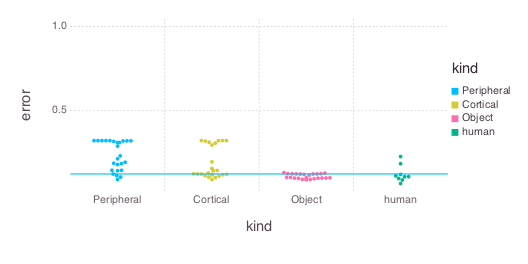

In [162]:
strplot = plot(dfstr_mul,y=:error,x=:kind,color=:kind,intercept=[mean(hstr.x1)],slope=[0],Geom.abline,Geom.beeswarm(padding=0.05mm),
    Coord.cartesian(ymax=1.0),Theme(point_size=0.5mm))
draw(PNG(5.5inch,2.75inch),strplot)
draw(PDF(joinpath(plotdir,"fig5B.pdf"),5.5inch,2.75inch),strplot)

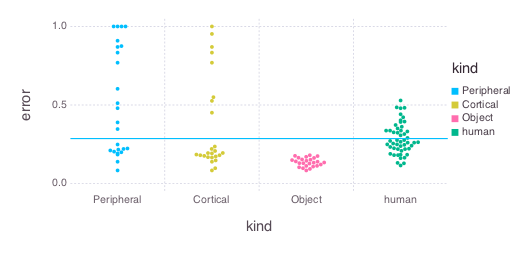

In [165]:
strplot = plot(dflen_mul,y=:error,x=:kind,color=:kind,intercept=[mean(hlen.x1)],slope=[0],Geom.abline,Geom.beeswarm(padding=0.05mm),Theme(point_size=0.5mm))
draw(PNG(5.5inch,2.75inch),strplot)
draw(PDF(joinpath(plotdir,"fig5C.pdf"),5.5inch,2.75inch),strplot)

In [ ]:
# TODO: bootstrap these estimates (probably speed up rms estimation first? or run on cluster??)

In [101]:
stats = by(vcat(dflevels...),:level) do x
    DataFrame(mean = mean(skipmissing(x.eratio)),min = minimum(skipmissing(x.eratio)))
end

,level,mean,min
,String,Float64,Float64
1,Peripheral,1.04424,0.439445
2,Cortical,0.837476,0.439445
3,Object,0.490771,0.439445


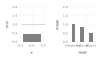

In [102]:
pl = hstack(plot(stats[stats.level.=="Cortical",:],x=[0],y=:min,intercept=[1.0],slope=[0],
                 Geom.bar,Geom.abline,Coord.cartesian(ymax=2.0),bartheme),
            plot(stats,x=:level,y=:mean,
                 Geom.bar,Coord.cartesian(ymax=2.0),Guide.xticks(orientation=:horizontal),bartheme))
draw(SVG(4inch,2.5inch),pl)
draw(PDF(joinpath(plotdir,"fig3D.pdf"),4inch,2.5inch),pl)